# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [14]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

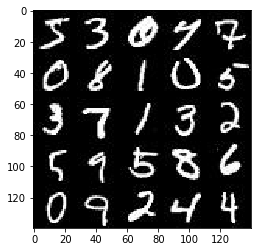

In [15]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

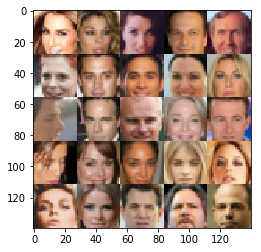

In [16]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [18]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32,(None, image_width, image_height, image_channels),name = 'input_real')
    inputs_z = tf.placeholder(tf.float32,(None, z_dim), name ='input_z')
    lr = tf.placeholder(tf.float32)
    return input_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [19]:
def discriminator(images, reuse=False): 
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse): 
        alpha = 0.2
        
        # Input layer is 32x32x3
        h1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * h1, h1)
        # 16x16x64
        
        h2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        h2 = tf.layers.batch_normalization(h2, training=True)
        relu2 = tf.maximum(alpha * h2, h2)
        # 8x8x128
        
        h3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        h3 = tf.layers.batch_normalization(h3, training=True)
        relu3 = tf.maximum(alpha * h3, h3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [30]:
def generator(z, out_channel_dim, is_train=True): 

    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        
        alpha = 0.2
        
        # Hidden layer
        h1 = tf.layers.dense(z, 7*7*512, activation=None)
        
        h1 = tf.reshape(h1, (-1, 7, 7, 256))
        
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        
        h1 = tf.maximum(h1,alpha * h1)
        #7*7*512
        
        h2 = tf.layers.conv2d_transpose(h1, 128, 5, strides=2, padding='same')

        h2 = tf.layers.batch_normalization(h2, training=is_train)
        
        h2 = tf.maximum(h2,alpha * h2)
        # 14x14x256 now
        
        # Logits and tanh output
        logits = tf.layers.conv2d_transpose(h2, out_channel_dim, 5, strides=2, padding='same')
        # 28x38xout_channel_dim now
        
        out = tf.tanh(logits)
        
        return out
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [21]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss
    
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [22]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [23]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [26]:
from tqdm import tqdm_notebook as pbar

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps = 0
    print_every=10
    show_every=100
    print (data_shape)
    
    if(data_image_mode == 'RGB'):
        image_channels = 3
    else:
        image_channels = 1
        
    image_width = data_shape[1]
    image_height = data_shape[2]
    
    print (batch_size)
    
    input_real, input_z, learn_rate = model_inputs(image_width,
                                       image_height,
                                       image_channels,
                                       z_dim)
    #print (input_real, input_z, learn_rate)
    
    
    d_loss,g_loss = model_loss(input_real, input_z, image_channels)
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)    
    
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in pbar(range(epoch_count), unit='epoch'):
            for batch_images in get_batches(batch_size):
                
                # Get images, reshape and rescale to pass to D
                image_input = 2 * batch_images #rescale
                
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: image_input, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: image_input, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: image_input, input_z: batch_z, learn_rate: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = sess.run(d_loss,{input_z: batch_z, input_real: image_input,learn_rate:learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                
                if steps % show_every == 0:
                    n_images = 25
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
        
        
        print("-------Done-------")

        


                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)
128


Epoch 1/10... Discriminator Loss: 2.1223... Generator Loss: 0.3116
Epoch 1/10... Discriminator Loss: 2.1619... Generator Loss: 0.6416
Epoch 1/10... Discriminator Loss: 1.8477... Generator Loss: 0.3873
Epoch 1/10... Discriminator Loss: 2.0098... Generator Loss: 0.3061
Epoch 1/10... Discriminator Loss: 1.8346... Generator Loss: 0.3333
Epoch 1/10... Discriminator Loss: 1.8704... Generator Loss: 0.3232
Epoch 1/10... Discriminator Loss: 1.6763... Generator Loss: 0.3578
Epoch 1/10... Discriminator Loss: 1.5402... Generator Loss: 0.7847
Epoch 1/10... Discriminator Loss: 1.6398... Generator Loss: 0.8071
Epoch 1/10... Discriminator Loss: 1.5240... Generator Loss: 1.1115


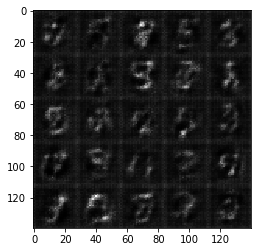

Epoch 1/10... Discriminator Loss: 1.3703... Generator Loss: 0.8541
Epoch 1/10... Discriminator Loss: 1.3408... Generator Loss: 0.6464
Epoch 1/10... Discriminator Loss: 1.3245... Generator Loss: 0.5468
Epoch 1/10... Discriminator Loss: 1.3576... Generator Loss: 0.5028
Epoch 1/10... Discriminator Loss: 1.1615... Generator Loss: 0.9257
Epoch 1/10... Discriminator Loss: 1.3917... Generator Loss: 0.4904
Epoch 1/10... Discriminator Loss: 1.5081... Generator Loss: 0.3488
Epoch 1/10... Discriminator Loss: 1.1221... Generator Loss: 0.6803
Epoch 1/10... Discriminator Loss: 1.0217... Generator Loss: 0.7215
Epoch 1/10... Discriminator Loss: 1.1318... Generator Loss: 0.8133


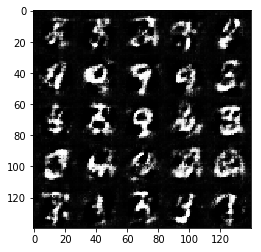

Epoch 1/10... Discriminator Loss: 1.3415... Generator Loss: 1.3104
Epoch 1/10... Discriminator Loss: 1.1296... Generator Loss: 0.7614
Epoch 1/10... Discriminator Loss: 1.1126... Generator Loss: 0.6774
Epoch 1/10... Discriminator Loss: 1.1802... Generator Loss: 0.7451
Epoch 1/10... Discriminator Loss: 1.2342... Generator Loss: 1.1771
Epoch 1/10... Discriminator Loss: 1.2477... Generator Loss: 1.2875
Epoch 1/10... Discriminator Loss: 1.1375... Generator Loss: 0.9779
Epoch 1/10... Discriminator Loss: 1.3566... Generator Loss: 0.4885
Epoch 1/10... Discriminator Loss: 1.3182... Generator Loss: 0.4882
Epoch 1/10... Discriminator Loss: 1.3212... Generator Loss: 0.6150


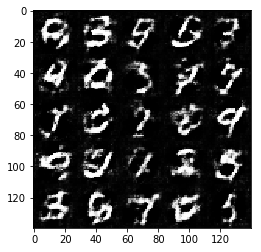

Epoch 1/10... Discriminator Loss: 1.4306... Generator Loss: 0.3760
Epoch 1/10... Discriminator Loss: 1.2673... Generator Loss: 0.5253
Epoch 1/10... Discriminator Loss: 1.3120... Generator Loss: 0.8147
Epoch 1/10... Discriminator Loss: 1.5008... Generator Loss: 0.7664
Epoch 1/10... Discriminator Loss: 1.3691... Generator Loss: 1.2415
Epoch 1/10... Discriminator Loss: 1.2928... Generator Loss: 0.7897
Epoch 1/10... Discriminator Loss: 1.2962... Generator Loss: 1.1515
Epoch 1/10... Discriminator Loss: 1.1698... Generator Loss: 0.7326
Epoch 1/10... Discriminator Loss: 1.3235... Generator Loss: 0.7361
Epoch 1/10... Discriminator Loss: 1.2468... Generator Loss: 0.9093


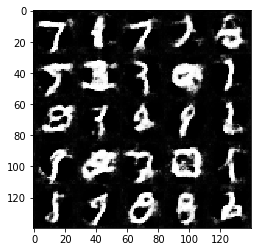

Epoch 1/10... Discriminator Loss: 1.3367... Generator Loss: 1.2716
Epoch 1/10... Discriminator Loss: 1.4239... Generator Loss: 0.3714
Epoch 1/10... Discriminator Loss: 1.2313... Generator Loss: 1.0776
Epoch 1/10... Discriminator Loss: 1.2425... Generator Loss: 0.5923
Epoch 1/10... Discriminator Loss: 1.3115... Generator Loss: 0.5096
Epoch 1/10... Discriminator Loss: 1.2433... Generator Loss: 0.7895


Epoch 2/10... Discriminator Loss: 1.3945... Generator Loss: 0.4631
Epoch 2/10... Discriminator Loss: 1.2224... Generator Loss: 0.9438
Epoch 2/10... Discriminator Loss: 1.3387... Generator Loss: 0.4938
Epoch 2/10... Discriminator Loss: 1.4089... Generator Loss: 0.4520


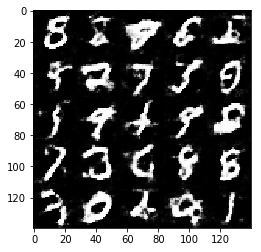

Epoch 2/10... Discriminator Loss: 1.2974... Generator Loss: 0.4995
Epoch 2/10... Discriminator Loss: 1.7183... Generator Loss: 0.2582
Epoch 2/10... Discriminator Loss: 1.2907... Generator Loss: 0.7513
Epoch 2/10... Discriminator Loss: 1.5767... Generator Loss: 0.3157
Epoch 2/10... Discriminator Loss: 1.3099... Generator Loss: 0.8060
Epoch 2/10... Discriminator Loss: 1.2423... Generator Loss: 0.5941
Epoch 2/10... Discriminator Loss: 1.2325... Generator Loss: 0.7424
Epoch 2/10... Discriminator Loss: 1.2691... Generator Loss: 1.0651
Epoch 2/10... Discriminator Loss: 1.3480... Generator Loss: 0.7110
Epoch 2/10... Discriminator Loss: 1.2169... Generator Loss: 0.5888


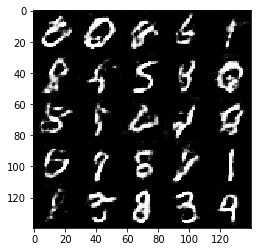

Epoch 2/10... Discriminator Loss: 1.2222... Generator Loss: 0.7800
Epoch 2/10... Discriminator Loss: 1.1543... Generator Loss: 0.9924
Epoch 2/10... Discriminator Loss: 1.3021... Generator Loss: 0.7351
Epoch 2/10... Discriminator Loss: 1.1042... Generator Loss: 0.7486
Epoch 2/10... Discriminator Loss: 1.2119... Generator Loss: 0.5419
Epoch 2/10... Discriminator Loss: 1.4433... Generator Loss: 0.3894
Epoch 2/10... Discriminator Loss: 1.2169... Generator Loss: 1.0505
Epoch 2/10... Discriminator Loss: 1.3977... Generator Loss: 0.4234
Epoch 2/10... Discriminator Loss: 1.0806... Generator Loss: 0.7727
Epoch 2/10... Discriminator Loss: 1.2583... Generator Loss: 0.5467


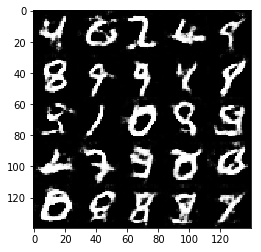

Epoch 2/10... Discriminator Loss: 1.3971... Generator Loss: 0.3950
Epoch 2/10... Discriminator Loss: 1.0690... Generator Loss: 0.9866
Epoch 2/10... Discriminator Loss: 1.4452... Generator Loss: 1.5564
Epoch 2/10... Discriminator Loss: 1.3765... Generator Loss: 0.4277
Epoch 2/10... Discriminator Loss: 1.1717... Generator Loss: 0.7252
Epoch 2/10... Discriminator Loss: 1.1306... Generator Loss: 0.8494
Epoch 2/10... Discriminator Loss: 1.4187... Generator Loss: 0.3691
Epoch 2/10... Discriminator Loss: 1.4195... Generator Loss: 0.4460
Epoch 2/10... Discriminator Loss: 1.2036... Generator Loss: 0.5482
Epoch 2/10... Discriminator Loss: 1.7390... Generator Loss: 0.2546


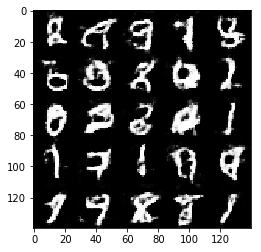

Epoch 2/10... Discriminator Loss: 1.1927... Generator Loss: 0.5596
Epoch 2/10... Discriminator Loss: 1.2304... Generator Loss: 0.6575
Epoch 2/10... Discriminator Loss: 1.2278... Generator Loss: 0.9519
Epoch 2/10... Discriminator Loss: 1.0702... Generator Loss: 0.7346
Epoch 2/10... Discriminator Loss: 1.5000... Generator Loss: 0.3445
Epoch 2/10... Discriminator Loss: 1.9211... Generator Loss: 0.1901
Epoch 2/10... Discriminator Loss: 1.2563... Generator Loss: 0.4860
Epoch 2/10... Discriminator Loss: 1.1428... Generator Loss: 0.5932
Epoch 2/10... Discriminator Loss: 1.1528... Generator Loss: 0.6844
Epoch 2/10... Discriminator Loss: 2.9249... Generator Loss: 0.0704


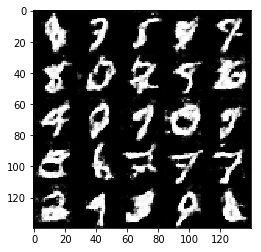

Epoch 2/10... Discriminator Loss: 1.4756... Generator Loss: 0.4932
Epoch 2/10... Discriminator Loss: 1.2227... Generator Loss: 0.5972
Epoch 2/10... Discriminator Loss: 1.0694... Generator Loss: 0.8423


Epoch 3/10... Discriminator Loss: 1.2456... Generator Loss: 0.6264
Epoch 3/10... Discriminator Loss: 1.1474... Generator Loss: 0.6866
Epoch 3/10... Discriminator Loss: 1.2546... Generator Loss: 1.3055
Epoch 3/10... Discriminator Loss: 1.1024... Generator Loss: 0.6889
Epoch 3/10... Discriminator Loss: 1.1549... Generator Loss: 0.6409
Epoch 3/10... Discriminator Loss: 1.3616... Generator Loss: 0.4217
Epoch 3/10... Discriminator Loss: 0.9792... Generator Loss: 0.9625


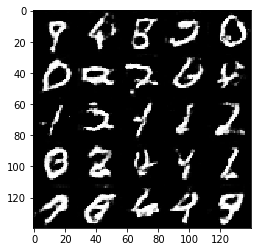

Epoch 3/10... Discriminator Loss: 2.5069... Generator Loss: 1.9766
Epoch 3/10... Discriminator Loss: 1.3439... Generator Loss: 0.4634
Epoch 3/10... Discriminator Loss: 1.1525... Generator Loss: 0.6542
Epoch 3/10... Discriminator Loss: 1.1551... Generator Loss: 0.6126
Epoch 3/10... Discriminator Loss: 1.3804... Generator Loss: 1.3430
Epoch 3/10... Discriminator Loss: 1.2134... Generator Loss: 0.6180
Epoch 3/10... Discriminator Loss: 2.1449... Generator Loss: 0.1830
Epoch 3/10... Discriminator Loss: 1.3831... Generator Loss: 0.5185
Epoch 3/10... Discriminator Loss: 1.3965... Generator Loss: 0.3737
Epoch 3/10... Discriminator Loss: 3.4102... Generator Loss: 0.0437


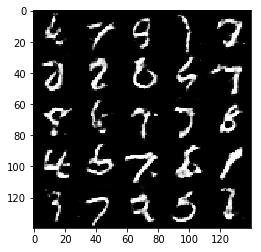

Epoch 3/10... Discriminator Loss: 1.0241... Generator Loss: 0.6869
Epoch 3/10... Discriminator Loss: 1.1657... Generator Loss: 0.6299
Epoch 3/10... Discriminator Loss: 1.6565... Generator Loss: 0.2984
Epoch 3/10... Discriminator Loss: 1.3560... Generator Loss: 0.3830
Epoch 3/10... Discriminator Loss: 1.4932... Generator Loss: 0.3629
Epoch 3/10... Discriminator Loss: 2.8183... Generator Loss: 2.5404
Epoch 3/10... Discriminator Loss: 1.2891... Generator Loss: 0.9014
Epoch 3/10... Discriminator Loss: 1.3431... Generator Loss: 0.4473
Epoch 3/10... Discriminator Loss: 1.0291... Generator Loss: 0.6912
Epoch 3/10... Discriminator Loss: 1.1608... Generator Loss: 0.7812


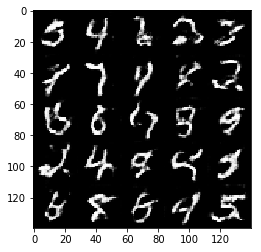

Epoch 3/10... Discriminator Loss: 1.1094... Generator Loss: 0.6162
Epoch 3/10... Discriminator Loss: 1.4747... Generator Loss: 0.3804
Epoch 3/10... Discriminator Loss: 1.1052... Generator Loss: 0.7073
Epoch 3/10... Discriminator Loss: 1.3169... Generator Loss: 0.5522
Epoch 3/10... Discriminator Loss: 1.4847... Generator Loss: 1.0492
Epoch 3/10... Discriminator Loss: 1.2275... Generator Loss: 0.6809
Epoch 3/10... Discriminator Loss: 1.2110... Generator Loss: 0.5383
Epoch 3/10... Discriminator Loss: 2.0438... Generator Loss: 0.1875
Epoch 3/10... Discriminator Loss: 1.3860... Generator Loss: 0.4307
Epoch 3/10... Discriminator Loss: 1.2987... Generator Loss: 0.4529


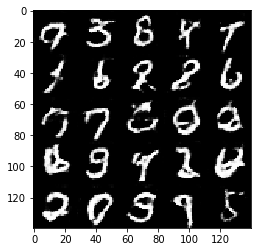

Epoch 3/10... Discriminator Loss: 1.5822... Generator Loss: 1.7048
Epoch 3/10... Discriminator Loss: 1.3308... Generator Loss: 0.4425
Epoch 3/10... Discriminator Loss: 1.2682... Generator Loss: 0.4584
Epoch 3/10... Discriminator Loss: 1.6100... Generator Loss: 0.4555
Epoch 3/10... Discriminator Loss: 1.4161... Generator Loss: 0.3622
Epoch 3/10... Discriminator Loss: 1.4028... Generator Loss: 0.3731
Epoch 3/10... Discriminator Loss: 0.8989... Generator Loss: 1.2973
Epoch 3/10... Discriminator Loss: 0.8956... Generator Loss: 0.9369
Epoch 3/10... Discriminator Loss: 1.3301... Generator Loss: 0.4515
Epoch 3/10... Discriminator Loss: 1.5113... Generator Loss: 0.3595


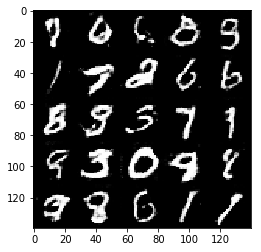

Epoch 4/10... Discriminator Loss: 1.1007... Generator Loss: 0.8594
Epoch 4/10... Discriminator Loss: 1.1075... Generator Loss: 1.2018
Epoch 4/10... Discriminator Loss: 1.6034... Generator Loss: 0.3051
Epoch 4/10... Discriminator Loss: 1.0032... Generator Loss: 0.8826
Epoch 4/10... Discriminator Loss: 1.1199... Generator Loss: 0.6147
Epoch 4/10... Discriminator Loss: 1.4014... Generator Loss: 0.3710
Epoch 4/10... Discriminator Loss: 1.6404... Generator Loss: 0.3473
Epoch 4/10... Discriminator Loss: 1.0947... Generator Loss: 0.8361
Epoch 4/10... Discriminator Loss: 1.2551... Generator Loss: 0.4502
Epoch 4/10... Discriminator Loss: 1.0718... Generator Loss: 0.5989


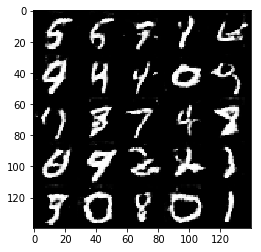

Epoch 4/10... Discriminator Loss: 0.7832... Generator Loss: 1.2930
Epoch 4/10... Discriminator Loss: 1.1472... Generator Loss: 0.5709
Epoch 4/10... Discriminator Loss: 1.3006... Generator Loss: 0.4469
Epoch 4/10... Discriminator Loss: 1.0022... Generator Loss: 1.0823
Epoch 4/10... Discriminator Loss: 1.5287... Generator Loss: 0.3280
Epoch 4/10... Discriminator Loss: 0.9874... Generator Loss: 0.6867
Epoch 4/10... Discriminator Loss: 1.4601... Generator Loss: 0.3542
Epoch 4/10... Discriminator Loss: 1.3053... Generator Loss: 0.8327
Epoch 4/10... Discriminator Loss: 1.0707... Generator Loss: 0.6701
Epoch 4/10... Discriminator Loss: 1.1807... Generator Loss: 0.5775


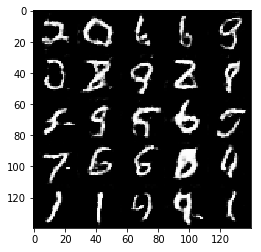

Epoch 4/10... Discriminator Loss: 1.2758... Generator Loss: 0.5194
Epoch 4/10... Discriminator Loss: 1.1992... Generator Loss: 0.5997
Epoch 4/10... Discriminator Loss: 1.4458... Generator Loss: 0.3738
Epoch 4/10... Discriminator Loss: 1.6653... Generator Loss: 0.2623
Epoch 4/10... Discriminator Loss: 1.0862... Generator Loss: 0.6641
Epoch 4/10... Discriminator Loss: 1.2594... Generator Loss: 0.7227
Epoch 4/10... Discriminator Loss: 0.9137... Generator Loss: 0.8540
Epoch 4/10... Discriminator Loss: 1.4062... Generator Loss: 0.3816
Epoch 4/10... Discriminator Loss: 1.0448... Generator Loss: 0.6488
Epoch 4/10... Discriminator Loss: 1.2270... Generator Loss: 0.4609


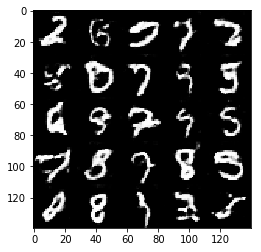

Epoch 4/10... Discriminator Loss: 1.1099... Generator Loss: 0.5618
Epoch 4/10... Discriminator Loss: 1.2808... Generator Loss: 0.4526
Epoch 4/10... Discriminator Loss: 1.9024... Generator Loss: 0.2310
Epoch 4/10... Discriminator Loss: 0.9681... Generator Loss: 1.0987
Epoch 4/10... Discriminator Loss: 1.1224... Generator Loss: 0.5792
Epoch 4/10... Discriminator Loss: 1.3598... Generator Loss: 0.3929
Epoch 4/10... Discriminator Loss: 0.9406... Generator Loss: 0.9216
Epoch 4/10... Discriminator Loss: 0.9892... Generator Loss: 0.6587
Epoch 4/10... Discriminator Loss: 1.6121... Generator Loss: 0.3263
Epoch 4/10... Discriminator Loss: 1.5819... Generator Loss: 0.3272


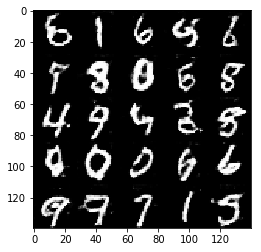

Epoch 4/10... Discriminator Loss: 1.5247... Generator Loss: 0.3686
Epoch 4/10... Discriminator Loss: 1.0075... Generator Loss: 0.6920
Epoch 4/10... Discriminator Loss: 2.0330... Generator Loss: 3.6095
Epoch 4/10... Discriminator Loss: 2.5435... Generator Loss: 3.1614
Epoch 4/10... Discriminator Loss: 1.3712... Generator Loss: 0.5392
Epoch 4/10... Discriminator Loss: 1.9402... Generator Loss: 0.1991
Epoch 4/10... Discriminator Loss: 1.0098... Generator Loss: 0.6871


Epoch 5/10... Discriminator Loss: 1.1811... Generator Loss: 0.5790
Epoch 5/10... Discriminator Loss: 1.2065... Generator Loss: 0.5512
Epoch 5/10... Discriminator Loss: 0.8003... Generator Loss: 1.0531


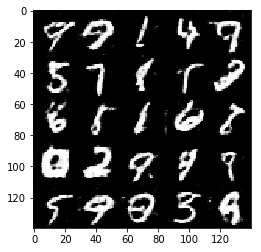

Epoch 5/10... Discriminator Loss: 1.2381... Generator Loss: 2.0117
Epoch 5/10... Discriminator Loss: 1.2205... Generator Loss: 0.4535
Epoch 5/10... Discriminator Loss: 1.4772... Generator Loss: 0.3597
Epoch 5/10... Discriminator Loss: 1.6766... Generator Loss: 0.3658
Epoch 5/10... Discriminator Loss: 0.8479... Generator Loss: 0.9985
Epoch 5/10... Discriminator Loss: 0.9119... Generator Loss: 0.8830
Epoch 5/10... Discriminator Loss: 1.3929... Generator Loss: 0.3975
Epoch 5/10... Discriminator Loss: 0.7889... Generator Loss: 0.9788
Epoch 5/10... Discriminator Loss: 1.1149... Generator Loss: 0.5629
Epoch 5/10... Discriminator Loss: 1.7838... Generator Loss: 0.2443


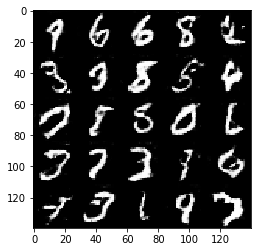

Epoch 5/10... Discriminator Loss: 1.2326... Generator Loss: 0.4709
Epoch 5/10... Discriminator Loss: 1.8682... Generator Loss: 0.2290
Epoch 5/10... Discriminator Loss: 1.2811... Generator Loss: 0.4873
Epoch 5/10... Discriminator Loss: 1.2525... Generator Loss: 0.4875
Epoch 5/10... Discriminator Loss: 0.9045... Generator Loss: 1.0996
Epoch 5/10... Discriminator Loss: 1.4667... Generator Loss: 0.3934
Epoch 5/10... Discriminator Loss: 1.6490... Generator Loss: 0.2878
Epoch 5/10... Discriminator Loss: 1.7973... Generator Loss: 3.2149
Epoch 5/10... Discriminator Loss: 0.8651... Generator Loss: 0.7825
Epoch 5/10... Discriminator Loss: 1.3348... Generator Loss: 0.4425


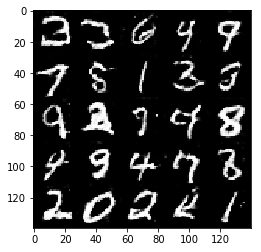

Epoch 5/10... Discriminator Loss: 1.0732... Generator Loss: 0.6039
Epoch 5/10... Discriminator Loss: 0.7942... Generator Loss: 1.0026
Epoch 5/10... Discriminator Loss: 1.2619... Generator Loss: 0.4637
Epoch 5/10... Discriminator Loss: 1.1548... Generator Loss: 0.5368
Epoch 5/10... Discriminator Loss: 1.6482... Generator Loss: 0.2923
Epoch 5/10... Discriminator Loss: 0.7911... Generator Loss: 1.8061
Epoch 5/10... Discriminator Loss: 0.7158... Generator Loss: 0.9750
Epoch 5/10... Discriminator Loss: 1.8444... Generator Loss: 0.2404
Epoch 5/10... Discriminator Loss: 1.0342... Generator Loss: 0.7012
Epoch 5/10... Discriminator Loss: 0.9769... Generator Loss: 0.7544


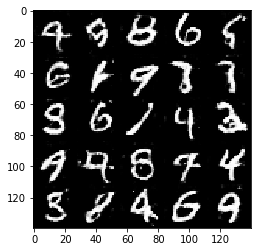

Epoch 5/10... Discriminator Loss: 0.8747... Generator Loss: 1.1030
Epoch 5/10... Discriminator Loss: 0.8778... Generator Loss: 0.7731
Epoch 5/10... Discriminator Loss: 1.9306... Generator Loss: 0.2171
Epoch 5/10... Discriminator Loss: 1.3171... Generator Loss: 0.4262
Epoch 5/10... Discriminator Loss: 1.2442... Generator Loss: 0.4421
Epoch 5/10... Discriminator Loss: 4.2818... Generator Loss: 0.0485
Epoch 5/10... Discriminator Loss: 0.9929... Generator Loss: 0.9211
Epoch 5/10... Discriminator Loss: 0.9268... Generator Loss: 0.9492
Epoch 5/10... Discriminator Loss: 0.9273... Generator Loss: 0.8365
Epoch 5/10... Discriminator Loss: 1.6126... Generator Loss: 0.2933


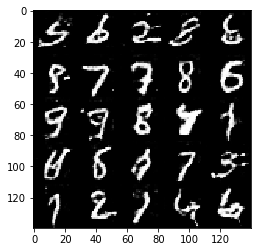

Epoch 5/10... Discriminator Loss: 0.7797... Generator Loss: 1.1364
Epoch 5/10... Discriminator Loss: 1.2742... Generator Loss: 0.4691
Epoch 5/10... Discriminator Loss: 1.1324... Generator Loss: 0.5811
Epoch 5/10... Discriminator Loss: 0.8013... Generator Loss: 0.9612


Epoch 6/10... Discriminator Loss: 1.3373... Generator Loss: 0.4380
Epoch 6/10... Discriminator Loss: 1.1377... Generator Loss: 0.5442
Epoch 6/10... Discriminator Loss: 1.3512... Generator Loss: 0.4266
Epoch 6/10... Discriminator Loss: 1.2864... Generator Loss: 0.4518
Epoch 6/10... Discriminator Loss: 1.6482... Generator Loss: 0.2977
Epoch 6/10... Discriminator Loss: 1.0632... Generator Loss: 0.6032


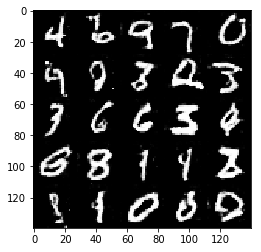

Epoch 6/10... Discriminator Loss: 1.2520... Generator Loss: 0.4651
Epoch 6/10... Discriminator Loss: 1.4502... Generator Loss: 0.3700
Epoch 6/10... Discriminator Loss: 0.9104... Generator Loss: 0.7950
Epoch 6/10... Discriminator Loss: 1.2865... Generator Loss: 2.9794
Epoch 6/10... Discriminator Loss: 1.5941... Generator Loss: 2.4119
Epoch 6/10... Discriminator Loss: 0.8569... Generator Loss: 0.9636
Epoch 6/10... Discriminator Loss: 0.8919... Generator Loss: 0.7472
Epoch 6/10... Discriminator Loss: 1.7272... Generator Loss: 0.2758
Epoch 6/10... Discriminator Loss: 1.0460... Generator Loss: 0.7203
Epoch 6/10... Discriminator Loss: 1.3346... Generator Loss: 0.4390


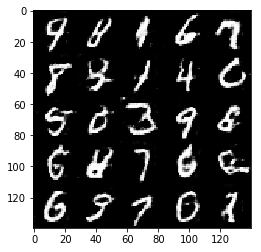

Epoch 6/10... Discriminator Loss: 1.1691... Generator Loss: 0.5628
Epoch 6/10... Discriminator Loss: 1.3856... Generator Loss: 0.4149
Epoch 6/10... Discriminator Loss: 1.4115... Generator Loss: 0.3802
Epoch 6/10... Discriminator Loss: 1.3046... Generator Loss: 0.4285
Epoch 6/10... Discriminator Loss: 0.8829... Generator Loss: 1.2843
Epoch 6/10... Discriminator Loss: 0.9316... Generator Loss: 0.9663
Epoch 6/10... Discriminator Loss: 0.8967... Generator Loss: 1.0468
Epoch 6/10... Discriminator Loss: 0.8815... Generator Loss: 0.8561
Epoch 6/10... Discriminator Loss: 0.9693... Generator Loss: 0.7565
Epoch 6/10... Discriminator Loss: 0.9213... Generator Loss: 1.8649


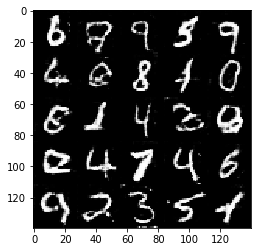

Epoch 6/10... Discriminator Loss: 1.1705... Generator Loss: 0.5361
Epoch 6/10... Discriminator Loss: 0.9859... Generator Loss: 0.6792
Epoch 6/10... Discriminator Loss: 1.4449... Generator Loss: 0.3636
Epoch 6/10... Discriminator Loss: 1.3003... Generator Loss: 0.4158
Epoch 6/10... Discriminator Loss: 1.0536... Generator Loss: 0.6235
Epoch 6/10... Discriminator Loss: 1.0817... Generator Loss: 0.5689
Epoch 6/10... Discriminator Loss: 1.2603... Generator Loss: 0.4490
Epoch 6/10... Discriminator Loss: 2.6112... Generator Loss: 0.1201
Epoch 6/10... Discriminator Loss: 1.3051... Generator Loss: 0.4404
Epoch 6/10... Discriminator Loss: 1.1901... Generator Loss: 0.5332


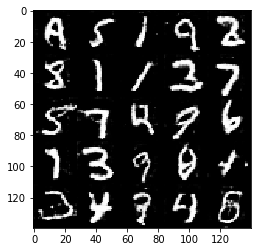

Epoch 6/10... Discriminator Loss: 1.0983... Generator Loss: 0.5685
Epoch 6/10... Discriminator Loss: 0.9113... Generator Loss: 0.7257
Epoch 6/10... Discriminator Loss: 1.3547... Generator Loss: 0.4124
Epoch 6/10... Discriminator Loss: 1.4041... Generator Loss: 0.3861
Epoch 6/10... Discriminator Loss: 0.6936... Generator Loss: 1.5548
Epoch 6/10... Discriminator Loss: 1.0188... Generator Loss: 0.7666
Epoch 6/10... Discriminator Loss: 1.1975... Generator Loss: 0.7014
Epoch 6/10... Discriminator Loss: 1.3521... Generator Loss: 2.2169
Epoch 6/10... Discriminator Loss: 1.0153... Generator Loss: 0.6245
Epoch 6/10... Discriminator Loss: 0.9861... Generator Loss: 0.8017


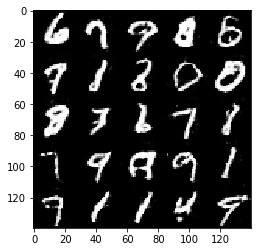

Epoch 7/10... Discriminator Loss: 1.2968... Generator Loss: 0.4423
Epoch 7/10... Discriminator Loss: 0.9817... Generator Loss: 0.7148
Epoch 7/10... Discriminator Loss: 1.1858... Generator Loss: 0.5290
Epoch 7/10... Discriminator Loss: 1.6439... Generator Loss: 0.3362
Epoch 7/10... Discriminator Loss: 1.1714... Generator Loss: 0.5652
Epoch 7/10... Discriminator Loss: 1.5381... Generator Loss: 0.3350
Epoch 7/10... Discriminator Loss: 1.2656... Generator Loss: 0.5924
Epoch 7/10... Discriminator Loss: 1.1995... Generator Loss: 0.5207
Epoch 7/10... Discriminator Loss: 1.1523... Generator Loss: 0.5276
Epoch 7/10... Discriminator Loss: 1.1856... Generator Loss: 0.5659


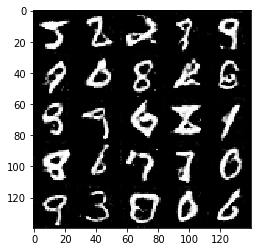

Epoch 7/10... Discriminator Loss: 1.3707... Generator Loss: 0.4149
Epoch 7/10... Discriminator Loss: 1.1710... Generator Loss: 0.4998
Epoch 7/10... Discriminator Loss: 1.0405... Generator Loss: 1.2356
Epoch 7/10... Discriminator Loss: 0.7021... Generator Loss: 1.4121
Epoch 7/10... Discriminator Loss: 0.7053... Generator Loss: 1.0184
Epoch 7/10... Discriminator Loss: 1.0610... Generator Loss: 0.6611
Epoch 7/10... Discriminator Loss: 0.6957... Generator Loss: 1.3279
Epoch 7/10... Discriminator Loss: 1.3840... Generator Loss: 0.4100
Epoch 7/10... Discriminator Loss: 1.2407... Generator Loss: 0.4909
Epoch 7/10... Discriminator Loss: 1.7721... Generator Loss: 0.2813


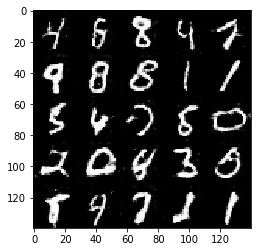

Epoch 7/10... Discriminator Loss: 1.4896... Generator Loss: 0.3710
Epoch 7/10... Discriminator Loss: 0.8250... Generator Loss: 1.0235
Epoch 7/10... Discriminator Loss: 0.6882... Generator Loss: 0.9809
Epoch 7/10... Discriminator Loss: 1.4732... Generator Loss: 0.3701
Epoch 7/10... Discriminator Loss: 1.2611... Generator Loss: 0.5061
Epoch 7/10... Discriminator Loss: 1.0125... Generator Loss: 0.6658
Epoch 7/10... Discriminator Loss: 1.5666... Generator Loss: 0.3407
Epoch 7/10... Discriminator Loss: 1.2013... Generator Loss: 0.5412
Epoch 7/10... Discriminator Loss: 1.7291... Generator Loss: 0.2883
Epoch 7/10... Discriminator Loss: 0.7878... Generator Loss: 1.1662


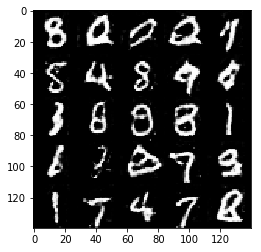

Epoch 7/10... Discriminator Loss: 0.8471... Generator Loss: 1.9067
Epoch 7/10... Discriminator Loss: 1.1056... Generator Loss: 0.8794
Epoch 7/10... Discriminator Loss: 1.0100... Generator Loss: 0.6408
Epoch 7/10... Discriminator Loss: 1.2670... Generator Loss: 0.4660
Epoch 7/10... Discriminator Loss: 1.8105... Generator Loss: 0.2685
Epoch 7/10... Discriminator Loss: 1.1830... Generator Loss: 0.6150
Epoch 7/10... Discriminator Loss: 1.1073... Generator Loss: 0.5494
Epoch 7/10... Discriminator Loss: 1.5930... Generator Loss: 0.3368
Epoch 7/10... Discriminator Loss: 1.7090... Generator Loss: 0.2802
Epoch 7/10... Discriminator Loss: 1.4306... Generator Loss: 0.3785


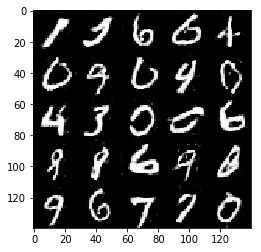

Epoch 7/10... Discriminator Loss: 1.4379... Generator Loss: 0.3842
Epoch 7/10... Discriminator Loss: 1.4641... Generator Loss: 0.3932
Epoch 7/10... Discriminator Loss: 0.9226... Generator Loss: 2.6208
Epoch 7/10... Discriminator Loss: 0.9081... Generator Loss: 1.0845
Epoch 7/10... Discriminator Loss: 1.2187... Generator Loss: 0.5324
Epoch 7/10... Discriminator Loss: 0.7118... Generator Loss: 1.7211
Epoch 7/10... Discriminator Loss: 0.8618... Generator Loss: 0.8630


Epoch 8/10... Discriminator Loss: 1.9699... Generator Loss: 3.5723
Epoch 8/10... Discriminator Loss: 0.8900... Generator Loss: 0.8238
Epoch 8/10... Discriminator Loss: 1.5994... Generator Loss: 0.3105


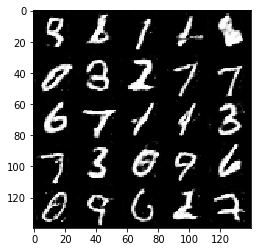

Epoch 8/10... Discriminator Loss: 1.6422... Generator Loss: 0.3054
Epoch 8/10... Discriminator Loss: 1.3493... Generator Loss: 0.4151
Epoch 8/10... Discriminator Loss: 1.2739... Generator Loss: 0.4666
Epoch 8/10... Discriminator Loss: 1.0068... Generator Loss: 0.6572
Epoch 8/10... Discriminator Loss: 1.5526... Generator Loss: 0.3295
Epoch 8/10... Discriminator Loss: 1.2592... Generator Loss: 0.4635
Epoch 8/10... Discriminator Loss: 1.2679... Generator Loss: 0.4735
Epoch 8/10... Discriminator Loss: 1.3349... Generator Loss: 0.4069
Epoch 8/10... Discriminator Loss: 1.6818... Generator Loss: 0.2786
Epoch 8/10... Discriminator Loss: 1.3347... Generator Loss: 0.4092


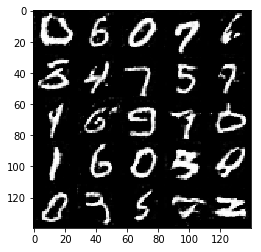

Epoch 8/10... Discriminator Loss: 1.3987... Generator Loss: 0.4153
Epoch 8/10... Discriminator Loss: 1.9526... Generator Loss: 0.2213
Epoch 8/10... Discriminator Loss: 0.8221... Generator Loss: 0.9739
Epoch 8/10... Discriminator Loss: 1.1427... Generator Loss: 0.5781
Epoch 8/10... Discriminator Loss: 1.0665... Generator Loss: 0.6159
Epoch 8/10... Discriminator Loss: 1.2778... Generator Loss: 0.4583
Epoch 8/10... Discriminator Loss: 1.2331... Generator Loss: 0.5349
Epoch 8/10... Discriminator Loss: 1.1959... Generator Loss: 0.5155
Epoch 8/10... Discriminator Loss: 1.5775... Generator Loss: 0.3272
Epoch 8/10... Discriminator Loss: 1.4631... Generator Loss: 0.3508


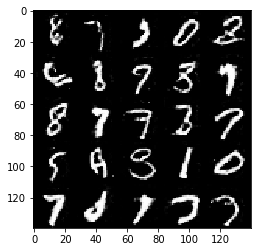

Epoch 8/10... Discriminator Loss: 0.9652... Generator Loss: 0.7182
Epoch 8/10... Discriminator Loss: 1.0395... Generator Loss: 0.6262
Epoch 8/10... Discriminator Loss: 1.6243... Generator Loss: 3.9083
Epoch 8/10... Discriminator Loss: 1.1182... Generator Loss: 0.6314
Epoch 8/10... Discriminator Loss: 1.2439... Generator Loss: 0.4998
Epoch 8/10... Discriminator Loss: 1.3289... Generator Loss: 0.4775
Epoch 8/10... Discriminator Loss: 1.1582... Generator Loss: 0.5504
Epoch 8/10... Discriminator Loss: 2.1103... Generator Loss: 0.1759
Epoch 8/10... Discriminator Loss: 0.7578... Generator Loss: 1.8005
Epoch 8/10... Discriminator Loss: 2.0080... Generator Loss: 0.2035


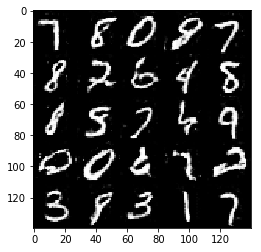

Epoch 8/10... Discriminator Loss: 1.0696... Generator Loss: 0.5835
Epoch 8/10... Discriminator Loss: 0.9579... Generator Loss: 0.7195
Epoch 8/10... Discriminator Loss: 1.6389... Generator Loss: 0.3105
Epoch 8/10... Discriminator Loss: 1.5664... Generator Loss: 0.3573
Epoch 8/10... Discriminator Loss: 1.3616... Generator Loss: 0.4590
Epoch 8/10... Discriminator Loss: 1.1627... Generator Loss: 0.5652
Epoch 8/10... Discriminator Loss: 1.1006... Generator Loss: 0.6574
Epoch 8/10... Discriminator Loss: 1.2010... Generator Loss: 0.5562
Epoch 8/10... Discriminator Loss: 1.1574... Generator Loss: 0.5688
Epoch 8/10... Discriminator Loss: 0.6719... Generator Loss: 2.4351


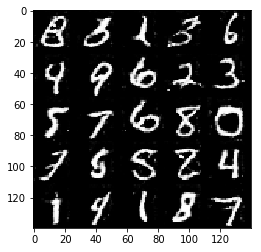

Epoch 8/10... Discriminator Loss: 0.6962... Generator Loss: 2.9236
Epoch 8/10... Discriminator Loss: 0.7071... Generator Loss: 1.4627
Epoch 8/10... Discriminator Loss: 0.7274... Generator Loss: 1.3008
Epoch 8/10... Discriminator Loss: 1.3929... Generator Loss: 0.3968


Epoch 9/10... Discriminator Loss: 0.6970... Generator Loss: 1.2119
Epoch 9/10... Discriminator Loss: 0.7968... Generator Loss: 0.9190
Epoch 9/10... Discriminator Loss: 1.7931... Generator Loss: 0.2830
Epoch 9/10... Discriminator Loss: 1.5067... Generator Loss: 0.3477
Epoch 9/10... Discriminator Loss: 1.1277... Generator Loss: 0.5291
Epoch 9/10... Discriminator Loss: 1.6797... Generator Loss: 0.3066


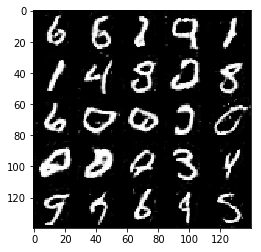

Epoch 9/10... Discriminator Loss: 2.8042... Generator Loss: 0.0882
Epoch 9/10... Discriminator Loss: 1.3761... Generator Loss: 0.4484
Epoch 9/10... Discriminator Loss: 0.8235... Generator Loss: 0.8723
Epoch 9/10... Discriminator Loss: 1.1145... Generator Loss: 0.5656
Epoch 9/10... Discriminator Loss: 0.8979... Generator Loss: 0.7066
Epoch 9/10... Discriminator Loss: 0.8310... Generator Loss: 0.8914
Epoch 9/10... Discriminator Loss: 1.1583... Generator Loss: 0.5212
Epoch 9/10... Discriminator Loss: 1.2199... Generator Loss: 0.4842
Epoch 9/10... Discriminator Loss: 1.8086... Generator Loss: 0.2729
Epoch 9/10... Discriminator Loss: 0.9562... Generator Loss: 0.8703


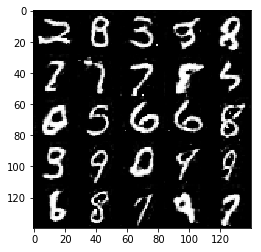

Epoch 9/10... Discriminator Loss: 1.5433... Generator Loss: 0.3958
Epoch 9/10... Discriminator Loss: 1.4907... Generator Loss: 0.3719
Epoch 9/10... Discriminator Loss: 0.5740... Generator Loss: 1.3897
Epoch 9/10... Discriminator Loss: 1.0708... Generator Loss: 0.6228
Epoch 9/10... Discriminator Loss: 1.6724... Generator Loss: 0.2980
Epoch 9/10... Discriminator Loss: 1.6836... Generator Loss: 0.2749
Epoch 9/10... Discriminator Loss: 1.1444... Generator Loss: 0.5408
Epoch 9/10... Discriminator Loss: 1.0664... Generator Loss: 0.7368
Epoch 9/10... Discriminator Loss: 0.8488... Generator Loss: 0.7817
Epoch 9/10... Discriminator Loss: 1.9952... Generator Loss: 0.2314


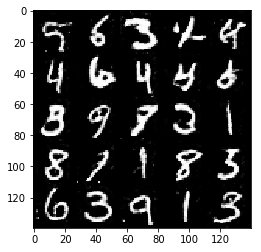

Epoch 9/10... Discriminator Loss: 0.5322... Generator Loss: 1.2827
Epoch 9/10... Discriminator Loss: 1.2147... Generator Loss: 0.5123
Epoch 9/10... Discriminator Loss: 0.8810... Generator Loss: 0.8177
Epoch 9/10... Discriminator Loss: 0.9712... Generator Loss: 0.6648
Epoch 9/10... Discriminator Loss: 0.8717... Generator Loss: 0.7877
Epoch 9/10... Discriminator Loss: 3.5258... Generator Loss: 0.0702
Epoch 9/10... Discriminator Loss: 0.7376... Generator Loss: 1.2359
Epoch 9/10... Discriminator Loss: 0.7068... Generator Loss: 1.1138
Epoch 9/10... Discriminator Loss: 0.6993... Generator Loss: 1.1195
Epoch 9/10... Discriminator Loss: 0.8021... Generator Loss: 0.9535


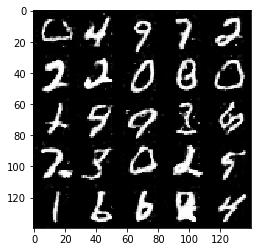

Epoch 9/10... Discriminator Loss: 0.9582... Generator Loss: 0.9870
Epoch 9/10... Discriminator Loss: 0.9210... Generator Loss: 0.7580
Epoch 9/10... Discriminator Loss: 1.3480... Generator Loss: 0.4407
Epoch 9/10... Discriminator Loss: 2.0363... Generator Loss: 0.2034
Epoch 9/10... Discriminator Loss: 1.4576... Generator Loss: 0.3626
Epoch 9/10... Discriminator Loss: 0.7483... Generator Loss: 0.9390
Epoch 9/10... Discriminator Loss: 0.9811... Generator Loss: 0.7032
Epoch 9/10... Discriminator Loss: 3.9775... Generator Loss: 4.1838
Epoch 9/10... Discriminator Loss: 0.7706... Generator Loss: 1.3720
Epoch 9/10... Discriminator Loss: 1.3401... Generator Loss: 0.4732


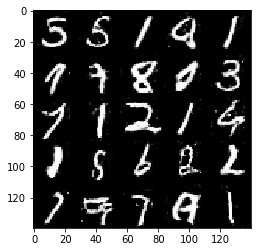

Epoch 9/10... Discriminator Loss: 0.9036... Generator Loss: 1.9836


Epoch 10/10... Discriminator Loss: 0.6542... Generator Loss: 1.0682
Epoch 10/10... Discriminator Loss: 1.0492... Generator Loss: 0.8684
Epoch 10/10... Discriminator Loss: 0.7930... Generator Loss: 1.0321
Epoch 10/10... Discriminator Loss: 1.2872... Generator Loss: 0.4676
Epoch 10/10... Discriminator Loss: 1.0977... Generator Loss: 0.5507
Epoch 10/10... Discriminator Loss: 1.3775... Generator Loss: 0.4518
Epoch 10/10... Discriminator Loss: 1.6711... Generator Loss: 0.4405
Epoch 10/10... Discriminator Loss: 0.8422... Generator Loss: 0.8246
Epoch 10/10... Discriminator Loss: 0.9923... Generator Loss: 0.7030


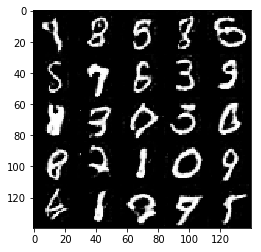

Epoch 10/10... Discriminator Loss: 1.0268... Generator Loss: 0.6186
Epoch 10/10... Discriminator Loss: 0.9918... Generator Loss: 0.6768
Epoch 10/10... Discriminator Loss: 0.7601... Generator Loss: 1.0121
Epoch 10/10... Discriminator Loss: 2.0820... Generator Loss: 0.1919
Epoch 10/10... Discriminator Loss: 1.4046... Generator Loss: 0.3925
Epoch 10/10... Discriminator Loss: 1.5596... Generator Loss: 0.3452
Epoch 10/10... Discriminator Loss: 1.2640... Generator Loss: 0.5075
Epoch 10/10... Discriminator Loss: 0.8166... Generator Loss: 1.5011
Epoch 10/10... Discriminator Loss: 1.2842... Generator Loss: 0.4799
Epoch 10/10... Discriminator Loss: 1.0223... Generator Loss: 0.6531


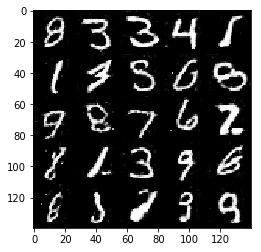

Epoch 10/10... Discriminator Loss: 2.6569... Generator Loss: 0.1178
Epoch 10/10... Discriminator Loss: 1.1141... Generator Loss: 0.5879
Epoch 10/10... Discriminator Loss: 0.6903... Generator Loss: 1.2639
Epoch 10/10... Discriminator Loss: 1.6296... Generator Loss: 0.3141
Epoch 10/10... Discriminator Loss: 1.1420... Generator Loss: 0.5828
Epoch 10/10... Discriminator Loss: 1.3101... Generator Loss: 0.4345
Epoch 10/10... Discriminator Loss: 1.0874... Generator Loss: 0.6301
Epoch 10/10... Discriminator Loss: 1.3087... Generator Loss: 0.4686
Epoch 10/10... Discriminator Loss: 1.4126... Generator Loss: 0.4279
Epoch 10/10... Discriminator Loss: 1.5468... Generator Loss: 0.3582


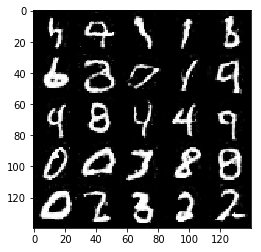

Epoch 10/10... Discriminator Loss: 0.7330... Generator Loss: 0.9033
Epoch 10/10... Discriminator Loss: 1.5777... Generator Loss: 0.3541
Epoch 10/10... Discriminator Loss: 1.6293... Generator Loss: 0.3151
Epoch 10/10... Discriminator Loss: 0.7469... Generator Loss: 0.9090
Epoch 10/10... Discriminator Loss: 1.7142... Generator Loss: 0.2945
Epoch 10/10... Discriminator Loss: 0.6520... Generator Loss: 1.1307
Epoch 10/10... Discriminator Loss: 1.8039... Generator Loss: 0.2953
Epoch 10/10... Discriminator Loss: 1.3283... Generator Loss: 0.4520
Epoch 10/10... Discriminator Loss: 1.4831... Generator Loss: 0.3702
Epoch 10/10... Discriminator Loss: 1.2778... Generator Loss: 0.4829


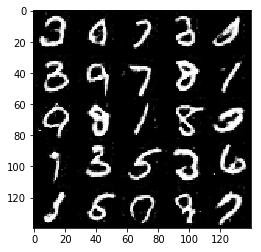

Epoch 10/10... Discriminator Loss: 0.9287... Generator Loss: 0.6979
Epoch 10/10... Discriminator Loss: 0.9446... Generator Loss: 0.7283
Epoch 10/10... Discriminator Loss: 1.7529... Generator Loss: 0.2968
Epoch 10/10... Discriminator Loss: 0.9889... Generator Loss: 0.9546
Epoch 10/10... Discriminator Loss: 0.7915... Generator Loss: 1.1056
Epoch 10/10... Discriminator Loss: 1.1954... Generator Loss: 0.5027
Epoch 10/10... Discriminator Loss: 0.8317... Generator Loss: 1.1904
Epoch 10/10... Discriminator Loss: 0.8520... Generator Loss: 0.8881
-------Done-------


In [27]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 10

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(202599, 28, 28, 3)
128



Epoch 1/1... Discriminator Loss: 3.5340... Generator Loss: 1.2740
Epoch 1/1... Discriminator Loss: 2.1308... Generator Loss: 0.7501
Epoch 1/1... Discriminator Loss: 1.7811... Generator Loss: 0.3940
Epoch 1/1... Discriminator Loss: 2.0375... Generator Loss: 0.6474
Epoch 1/1... Discriminator Loss: 1.8346... Generator Loss: 0.8359
Epoch 1/1... Discriminator Loss: 1.6712... Generator Loss: 0.7316
Epoch 1/1... Discriminator Loss: 1.6397... Generator Loss: 0.5399
Epoch 1/1... Discriminator Loss: 1.5849... Generator Loss: 0.5778
Epoch 1/1... Discriminator Loss: 1.6704... Generator Loss: 0.9853
Epoch 1/1... Discriminator Loss: 1.7167... Generator Loss: 0.7271


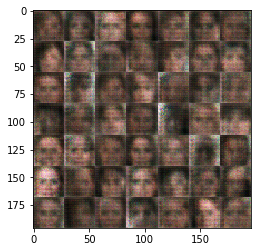

Epoch 1/1... Discriminator Loss: 1.6825... Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 1.6032... Generator Loss: 0.6787
Epoch 1/1... Discriminator Loss: 1.7326... Generator Loss: 0.7823
Epoch 1/1... Discriminator Loss: 1.5254... Generator Loss: 0.7398
Epoch 1/1... Discriminator Loss: 1.5299... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 1.6788... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 1.6078... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.5509... Generator Loss: 0.5832
Epoch 1/1... Discriminator Loss: 1.6170... Generator Loss: 0.6649
Epoch 1/1... Discriminator Loss: 1.8330... Generator Loss: 0.3020


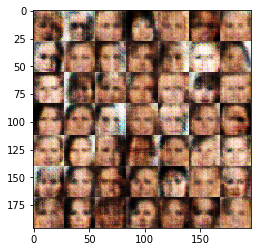

Epoch 1/1... Discriminator Loss: 1.5139... Generator Loss: 0.5627
Epoch 1/1... Discriminator Loss: 1.5529... Generator Loss: 0.8596
Epoch 1/1... Discriminator Loss: 1.5888... Generator Loss: 0.7134
Epoch 1/1... Discriminator Loss: 1.5192... Generator Loss: 0.6473
Epoch 1/1... Discriminator Loss: 1.5277... Generator Loss: 0.6618
Epoch 1/1... Discriminator Loss: 1.5377... Generator Loss: 0.5751
Epoch 1/1... Discriminator Loss: 1.4965... Generator Loss: 0.5963
Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.7489
Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.6757
Epoch 1/1... Discriminator Loss: 1.5307... Generator Loss: 0.5184


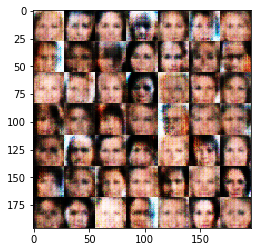

Epoch 1/1... Discriminator Loss: 1.6446... Generator Loss: 0.4475
Epoch 1/1... Discriminator Loss: 1.5601... Generator Loss: 0.4178
Epoch 1/1... Discriminator Loss: 1.4687... Generator Loss: 0.5376
Epoch 1/1... Discriminator Loss: 1.9726... Generator Loss: 0.2801
Epoch 1/1... Discriminator Loss: 1.4717... Generator Loss: 0.6957
Epoch 1/1... Discriminator Loss: 1.5068... Generator Loss: 0.5343
Epoch 1/1... Discriminator Loss: 1.2765... Generator Loss: 1.1608
Epoch 1/1... Discriminator Loss: 1.2103... Generator Loss: 1.0005
Epoch 1/1... Discriminator Loss: 1.1446... Generator Loss: 0.8853
Epoch 1/1... Discriminator Loss: 1.4528... Generator Loss: 0.6335


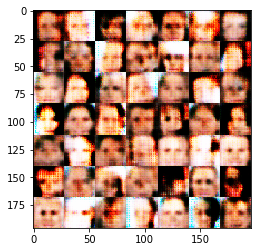

Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.6897
Epoch 1/1... Discriminator Loss: 1.5030... Generator Loss: 0.6726
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.7539
Epoch 1/1... Discriminator Loss: 1.5492... Generator Loss: 0.5521
Epoch 1/1... Discriminator Loss: 1.5209... Generator Loss: 0.5648
Epoch 1/1... Discriminator Loss: 1.5159... Generator Loss: 0.5187
Epoch 1/1... Discriminator Loss: 1.4739... Generator Loss: 0.5799
Epoch 1/1... Discriminator Loss: 1.5487... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.4994... Generator Loss: 0.6246


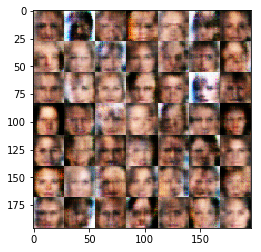

Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.7175
Epoch 1/1... Discriminator Loss: 1.4843... Generator Loss: 0.5335
Epoch 1/1... Discriminator Loss: 1.4528... Generator Loss: 0.5897
Epoch 1/1... Discriminator Loss: 1.4406... Generator Loss: 0.6770
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.4458... Generator Loss: 0.6620
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.6628
Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 1.4901... Generator Loss: 0.5283


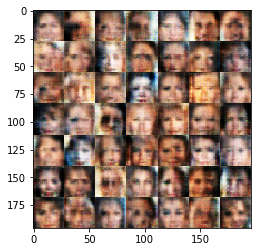

Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.7712
Epoch 1/1... Discriminator Loss: 1.4616... Generator Loss: 0.6741
Epoch 1/1... Discriminator Loss: 1.4365... Generator Loss: 0.7083
Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.6370
Epoch 1/1... Discriminator Loss: 1.4807... Generator Loss: 0.6307
Epoch 1/1... Discriminator Loss: 1.4993... Generator Loss: 0.6632
Epoch 1/1... Discriminator Loss: 1.4698... Generator Loss: 0.6067
Epoch 1/1... Discriminator Loss: 1.5184... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.6878
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.7064


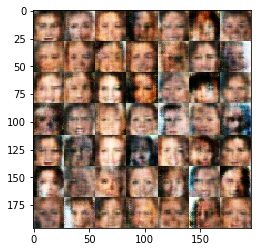

Epoch 1/1... Discriminator Loss: 1.4343... Generator Loss: 0.6858
Epoch 1/1... Discriminator Loss: 1.4616... Generator Loss: 0.6779
Epoch 1/1... Discriminator Loss: 1.4809... Generator Loss: 0.5931
Epoch 1/1... Discriminator Loss: 1.5142... Generator Loss: 0.7056
Epoch 1/1... Discriminator Loss: 1.4387... Generator Loss: 0.6735
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.6197
Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.6609
Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 0.6416
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.7139


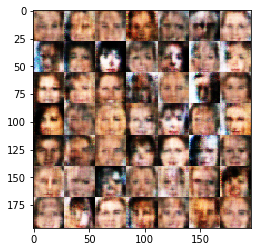

Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.6583
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.6936
Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.6524
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.6808
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.7209
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.6115
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.5459
Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.6563
Epoch 1/1... Discriminator Loss: 1.4551... Generator Loss: 0.6355


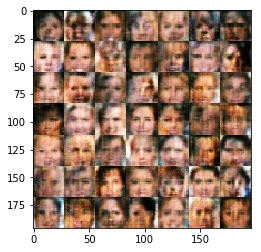

Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.6283
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.6932
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.6529
Epoch 1/1... Discriminator Loss: 1.4776... Generator Loss: 0.6060
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.7028
Epoch 1/1... Discriminator Loss: 1.4379... Generator Loss: 0.7147
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.6958
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.7754
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.6811


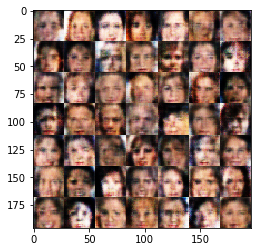

Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.5652
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.5960
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.7064
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.5994
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.6960
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.5967
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.6568
Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.6556


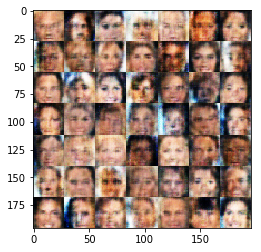

Epoch 1/1... Discriminator Loss: 1.4993... Generator Loss: 0.5804
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.7049
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.7012
Epoch 1/1... Discriminator Loss: 1.4406... Generator Loss: 0.7495
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.7399
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.6576
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.6225
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.6365
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.6374
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.7493


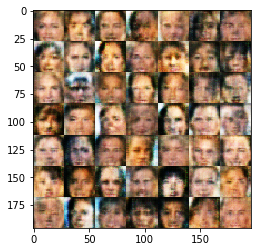

Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.7453
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.6328
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.6681
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.7185
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.7047
Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.6503
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.6274
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.7158
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.6466


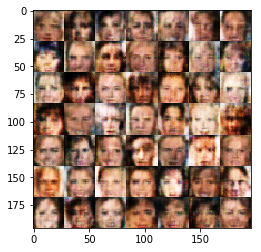

Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.6319
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.6827
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.7221
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 0.6183
Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 0.6397
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.6096
Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.8069
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.6801


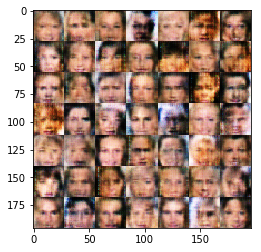

Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.6730
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.6178
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.5981
Epoch 1/1... Discriminator Loss: 1.4814... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 1.5109... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.5906
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.6742
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.6879
Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 0.6573


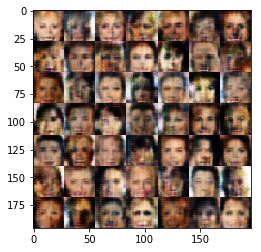

Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.6826
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.7302
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.7286
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.5877
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.7054
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.7332
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.7287
-------Done-------


In [31]:
batch_size = 128
z_dim = 100
learning_rate = 0.002
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.